<a href="https://colab.research.google.com/github/pablojrios/fluence_maps/blob/master/tf2_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compute predictions on a TF dataset using an stored .h5 model

In [1]:
def isGoogleColab():
    # 'ipykernel.zmqshell' runs in our server
    # 'google.colab._shell' runs in Google Colab
    return get_ipython().__class__.__module__ == 'google.colab._shell'

In [2]:
import numpy as np
import tensorflow as tf
from util.dataset import _tfrecord_dataset_type_from_folder, _parse_jpeg_image_function
from util.preprocess import rescale_0_to_1
import os
import pandas as pd
# Es indistinto usar las métricas de scikit learn o tensorflow
# from sklearn.metrics import mean_absolute_error
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
print('Tensorflow version = {}'.format(tf.__version__))
print('Executing eagerly = {}'.format(tf.executing_eagerly()))

Tensorflow version = 2.2.0
Executing eagerly = True


In [4]:
#%cd /content/drive/My\ Drive/Healthcare/Radioterapia/data/ciolaplata
#!unrar x /content/drive/My\ Drive/Healthcare/Radioterapia/Mapas\ CIO\ La\ Plata/Mapas\ Calculados/2019.rar
#!ls -l 2015/*dcm | wc -l

if isGoogleColab():
    %cd -q '/content'
    if os.path.exists('fluence_maps'):
        !rm -fr fluence_maps

    GIT_USERNAME = "pablojrios"
    GIT_TOKEN = "1d88a0b85d2b00a03796e4d8b7e5f7b249b12f9b"
    !git clone -s https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/fluence_maps.git

    from google.colab import drive
    drive.mount('/content/drive')
    
    !ls -l '/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata/models'
    
    ARG_DATASET_DIR='/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata'

In [5]:
#============================DEFINE YOUR ARGUMENTS==============================
if not isGoogleColab():
    # base data directory
    ARG_DATASET_DIR='/hdd/data/radioterapia/ciolaplata'
# folder under ARG_DATASET_DIR path.
ARG_TFDATASET_FOLDER='tfds.2019.localnorm.12345.ovs97x3'
ARG_MODEL_NAME = '1611186835' # VGG16 20 de enero 2021
# ARG_MODEL_NAME = '1611181684' # ResNet 18 20 de enero 2021
# 'train', 'validation', 'test' 
ARG_PART = 'train'
ARG_TRANSFORM_GAMMA=False

In [6]:
tfdataset_dir = os.path.join(ARG_DATASET_DIR, ARG_TFDATASET_FOLDER)
raw_test = _tfrecord_dataset_type_from_folder(tfdataset_dir, ARG_PART)
print(raw_test)

<TFRecordDatasetV2 shapes: (), types: tf.string>


In [7]:
# Apply this function to each item in the dataset using the map method:
num_workers = 8
IMG_SIZE = 256
normalization_fn = rescale_0_to_1
test = raw_test.map(lambda e: _parse_jpeg_image_function(e, IMG_SIZE, normalization_fn, transform_gamma=ARG_TRANSFORM_GAMMA), num_parallel_calls=num_workers)
print(test)

<ParallelMapDataset shapes: ((256, 256, 3), (), ()), types: (tf.float32, tf.float32, tf.string)>


In [8]:
gamma_values = test.map(lambda image, gamma, filename: gamma)
gamma_values = np.array(list(gamma_values.as_numpy_iterator()))
BATCH_SIZE = 32 # mae puede variar según batch size.
test_batches = test.batch(BATCH_SIZE)
print(test_batches)

<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>


In [9]:
gamma_values

array([98.6662 , 99.39581, 97.1279 , ..., 99.21586, 98.3763 , 98.5434 ],
      dtype=float32)

In [10]:
# load model
dir = os.path.join(ARG_DATASET_DIR, "models")
saved_model_dir = '{}/{}.h5'.format(dir, ARG_MODEL_NAME)
print(f'Loading model {saved_model_dir}...')
loaded_model = tf.keras.models.load_model(saved_model_dir)

Loading model /hdd/data/radioterapia/ciolaplata/models/1611186835.h5...


In [11]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,977,857
Trainable params: 12,062,209
Non-trainable params: 2,915,648
_________________________________________________________________


In [12]:
# Evaluate dataset with the loaded model to calculate loss (mae) because
# metric value could differ from the one reported during training.
tmp_test_batches = test_batches.map(lambda image, gamma, filename: (image, gamma))
print(tmp_test_batches)
loss, mse = loaded_model.evaluate(tmp_test_batches, workers=num_workers, verbose=0)
print('\n\nLoaded model, test loss: {:5.4f}'.format(loss))
print('Loaded model, test mse: {:5.4f}'.format(mse))

<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.float32)>


Loaded model, test loss: 0.8341
Loaded model, test mse: 4.1350


In [13]:
# For VGG16 only
#inputs=loaded_model.get_layer("vgg16").input
#outputs=loaded_model.get_layer("vgg16").output
#cnn_part=tf.keras.models.Model(inputs, outputs)
#cnn_part.summary()
#predictions = cnn_part.predict(tmp_test_batches)

In [14]:
# For VGG16 only
#predictions[0][:,:,3]

In [15]:
# For VGG16 only
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#feature_batch_average = global_average_layer(predictions)
#feature_batch_average[0]

In [16]:
# For VGG16 only
#from math import isclose
#a=predictions[0][:,:,3].mean()
#b=feature_batch_average[0][3].numpy()
#isclose(a, b, rel_tol=1e-7)

In [17]:
# Make predictions
predictions = loaded_model.predict(tmp_test_batches)
# from (1121,1) to (1121,); ie.: ndim = 2 to ndim = 1
predictions = predictions.reshape(-1)

In [18]:
tmp_test_batches = test.map(lambda image, gamma, filename: (filename, gamma))
lst = [(filename.numpy().decode('utf-8'), gamma.numpy()) for filename, gamma in tmp_test_batches]
lst2 = [(e[0], e[1], p) for e, p in zip(lst, predictions)]

# armar un pandas dataframe con el test set completo
df = pd.DataFrame(lst2, columns=['filename', 'actual gamma', 'predicted gamma'])
dir = os.path.join(ARG_DATASET_DIR, "predictions")
predictions_file_path = '{}/predicted_gamma_{}.{}.csv'.format(dir, ARG_MODEL_NAME, ARG_PART)
df.to_csv(predictions_file_path, index=False)
print(f'Predictions saved to {predictions_file_path}.')

Predictions saved to /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1611186835.train.csv.


In [19]:
def display_scatterplot(part, y, y_hat):
    # mean average error
    mae = mean_absolute_error(y, y_hat)
    print('MAE on %s = %.3f' % (part, mae))

    # correlación entre predichos y observados
    corr = np.corrcoef(y, y_hat)[0,1]
    print('Corr. actual vs predicted = %.3f' % corr)

    r2score = r2_score(y, y_hat)
    print('R^2 = %.3f' % r2score)
    
    # plot calculados vs. predichos (targets)
    fig_dims = (8, 8)
    fig, ax = plt.subplots(figsize=fig_dims)
    plt.title('Actual vs. Predicted (%s)' % part)
    plt.gca().set_aspect('equal')
    sns.scatterplot(y, y_hat, marker='o', ax=ax)
    ax.set(xlabel="Actual", ylabel = "Predicted")
    plt.figure(figsize=(15, 15))
    minimum = int(np.min([y.min(), y_hat.min()]))
    ax.set_xlim([minimum, 100])
    ax.set_ylim([minimum, 100])
    ax.plot([minimum, 100], [minimum, 100], ls="--", c=".7")
    plt.show()

MAE on train = 0.834
Corr. actual vs predicted = 0.927
R^2 = 0.758


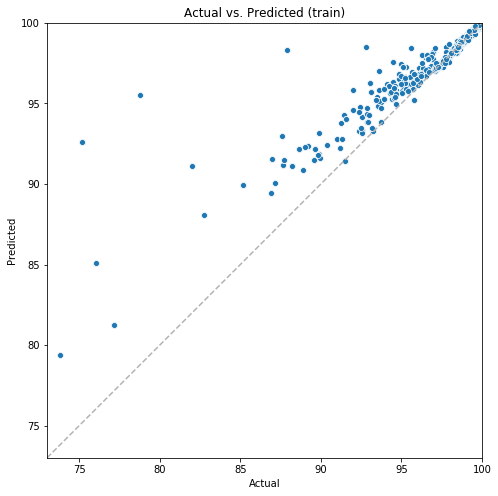

<Figure size 1080x1080 with 0 Axes>

In [20]:
y = df['actual gamma']
y_hat = df['predicted gamma']
display_scatterplot(ARG_PART, y, y_hat)

In [21]:
if isGoogleColab():
    drive.flush_and_unmount()
    print('All changes made in this colab session should now be visible in Drive.')